::: {#fig-cdmx}
![](https://www.economist.com/cdn-cgi/image/width=1424,quality=80,format=auto/sites/default/files/20180512_BLP504.jpg)

Mexico City Crimes
:::

# Introduction

It's important to recognize that crime trends are dynamic and influenced by various factors. Continued efforts are necessary to improve public safety and address the root causes of crime in Mexico City.

While efforts have been made to improve security through increased policing and community-based initiatives, persistent issues such as impunity and a lack of trust in law enforcement continue to hinder progress.

Addressing crime in Mexico City requires a multifaceted approach that includes improving data collection and analysis, strengthening law enforcement, and addressing the underlying socioeconomic factors that contribute to crime.

Analyzing crime trends in Mexico City requires considering both official statistics and the lived experiences of residents, as well as the interplay of local, national, and international forces.

Ongoing research and policy development are crucial to addressing the root causes of crime and fostering a safer environment for all.

# Environment settings

## Import libraries

In [1]:
#import libraries
import numpy as np
import pandas as pd
import polars as pl
import duckdb as db
import datetime as datetime
import json
import plotly.express as px
import folium
from folium.plugins import Fullscreen

## Database connection

In [3]:
# get token
filename = 'credentials.json'

# read json file
with open(filename) as f:
    keys = json.load(f)

# read credentials
token = keys['md_token']

[`Duckdb` is a powerful tool for data analysts and developers who need to perform fast and efficient analytical queries on large datasets, especially in environments where simplicity and portability are crucial.]{.aside}

In [4]:
# connect to motherduck cloud
conn = db.connect(f'md:?motherduck_token={token}')

In [ ]:
#| output: false
# retrieve dataframe
df = conn.execute('select * from projects.cdmx_fgj_uncleaned').pl()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
# close connection
conn.close()

In [2]:
#| echo: false
df = pd.read_csv('cdmx_fgj_uncleaned.csv')

In [3]:
print(f'The dataset contains {df.shape[0]:,.0f} rows')

The dataset contains 1,415,763 rows


## Missing values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415763 entries, 0 to 1415762
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   anio_inicio        1415748 non-null  float64
 1   mes_inicio         1415748 non-null  object 
 2   fecha_inicio       1415748 non-null  object 
 3   hora_inicio        1415748 non-null  object 
 4   anio_hecho         1415343 non-null  float64
 5   mes_hecho          1415343 non-null  object 
 6   fecha_hecho        1415342 non-null  object 
 7   hora_hecho         1415353 non-null  object 
 8   delito             1415749 non-null  object 
 9   categoria_delito   1415749 non-null  object 
 10  sexo               1168059 non-null  object 
 11  edad               931053 non-null   float64
 12  tipo_persona       1408196 non-null  object 
 13  calidad_juridica   1415748 non-null  object 
 14  competencia        1415749 non-null  object 
 15  colonia_hecho      1340796 non-n

In [5]:
df = df.dropna(subset=['latitud'])

In [6]:
print(f'The dataset now has {df.shape[0]:,.0f} rows')

The dataset now has 1,340,994 rows


::: {.callout-note}
We can see that the original dataset includes 1,415,763 rows.

However, there are many null values in different fields for considerable gaps.

As the dataset can be considered large, we decided to drop all null latitude rows, obtaining 1,340,994 rows.
:::

In [7]:
#| echo: false
print(f'Due to the missing rows in many fields,\
 we kept around with {round(1_340_994/1_415_763,4):.2%} of the original dataset')

Due to the missing rows in many fields, we kept around with 94.72% of the original dataset


## Polars dataframe

[`Polars` is a modern DataFrame library that prioritizes performance and efficiency. Its Rust-based architecture, combined with features like lazy evaluation and parallel processing, makes it a powerful tool for data professionals.]{.aside}

In [8]:
# convert to polars dataframe
df = pl.from_pandas(df)

In [9]:
df.schema

Schema([('anio_inicio', Float64),
        ('mes_inicio', String),
        ('fecha_inicio', String),
        ('hora_inicio', String),
        ('anio_hecho', Float64),
        ('mes_hecho', String),
        ('fecha_hecho', String),
        ('hora_hecho', String),
        ('delito', String),
        ('categoria_delito', String),
        ('sexo', String),
        ('edad', Float64),
        ('tipo_persona', String),
        ('calidad_juridica', String),
        ('competencia', String),
        ('colonia_hecho', String),
        ('colonia_catalogo', String),
        ('alcaldia_hecho', String),
        ('alcaldia_catalogo', String),
        ('municipio_hecho', String),
        ('latitud', Float64),
        ('longitud', Float64)])

## Data cleansing

In [10]:
df = (
    df.filter(
    # drop null and 2018 years
        (pl.col('anio_inicio')!=2018)
    ).with_columns(
    # create datetime field
        (pl.col('fecha_inicio').cast(pl.String) + ' ' + pl.col('hora_inicio')
             .cast(pl.String)).alias('fecha_inicio')
    ).select(
    # exclude columns
        pl.exclude('anio_inicio','mes_inicio','hora_inicio',
                   'anio_hecho','mes_hecho','fecha_hecho','hora_hecho')
    ).with_columns(
        fecha_inicio=pl.col('fecha_inicio').str.to_datetime()
    ).drop_nulls(subset='fecha_inicio')
)

In [11]:
df.select(pl.all().is_null().sum()).to_dicts()

[{'fecha_inicio': 0,
  'delito': 0,
  'categoria_delito': 0,
  'sexo': 237070,
  'edad': 449780,
  'tipo_persona': 6858,
  'calidad_juridica': 1,
  'competencia': 0,
  'colonia_hecho': 382,
  'colonia_catalogo': 17677,
  'alcaldia_hecho': 3,
  'alcaldia_catalogo': 953,
  'municipio_hecho': 3,
  'latitud': 0,
  'longitud': 0}]

::: {.callout-note}
We can see that even if we dropped around 75,000 rows, there continue to be many fields with empty rows, such as sex, age, neighborhood, mayorship and municipality.
:::

## Data cleaning for age

In [12]:
#| echo: false
print(f'Age goes from {df['edad'].min()} up to {df['edad'].max()} years old!')

Age goes from 0.0 up to 369.0 years old!


In [13]:
# case for age
df = df.with_columns(
    pl.when(pl.col('edad') < 18).then(18)
    .when(pl.col('edad')>99).then(99)
    .otherwise('edad')
    .alias('edad')
)

We have cleaned age values by setting age less than 18 to 18, and age values gretar than 99 to 99.

# Exploratory Data Analysis

## Accrued crimes by year

In [14]:
years = (
    df.sort('fecha_inicio')
        .group_by_dynamic('fecha_inicio', every='1y')
        .agg(pl.len().alias('crimes'))
)

In [15]:
#| label: tbl-years
#| tbl-cap: "Accrued Crimes in Mexico City by Year"
#| tbl-cap-location: margin

(
    years
        .to_pandas()
        .style.format(
            {
            'fecha_inicio':'{:%Y}',
            'crimes':'{:,.0f}',
            }
        ).hide(axis='index')
)

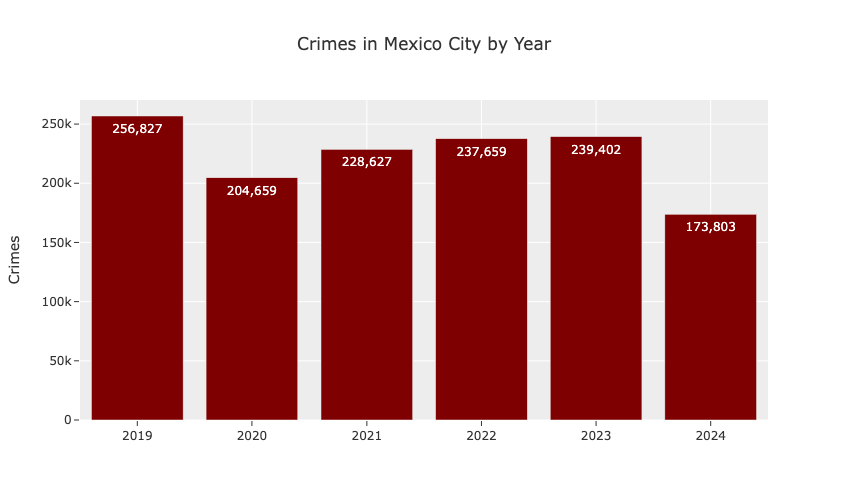

In [16]:
#| label: fig-years
#| fig-cap: "Crimes in Mexico City by Year"
#| fig-cap-location: margin

fig = px.bar(years, 
             x='fecha_inicio',
             y='crimes',
             orientation='v',
             hover_data=['fecha_inicio','crimes',],
             height=500,
             width=830,
             title='Crimes in Mexico City by Year',
             template='ggplot2',)

fig.update_layout(
    xaxis=dict(title=dict(text='')),
    yaxis=dict(title=dict(text='Crimes')),
    )

fig.update_traces(marker_color='#7f0000',
                 texttemplate = "%{value:,.0f}",)

fig.show()

## Time behavior of crimes

In [17]:
months = (
    df
        .sort('fecha_inicio', descending=False)
        .group_by_dynamic('fecha_inicio', every='1mo')
        .agg(pl.len().alias('crimes'))
)

In [18]:
#| label: tbl-time
#| tbl-cap: "Accrued Crimes in Mexico City by Month"
#| tbl-cap-location: margin

(
    months
        .to_pandas()
        .tail(10)
        .style.format(
            {
            'fecha_inicio':'{:%b, %Y}',
            'crimes':'{:,.0f}',
            }
        ).hide(axis='index')
)

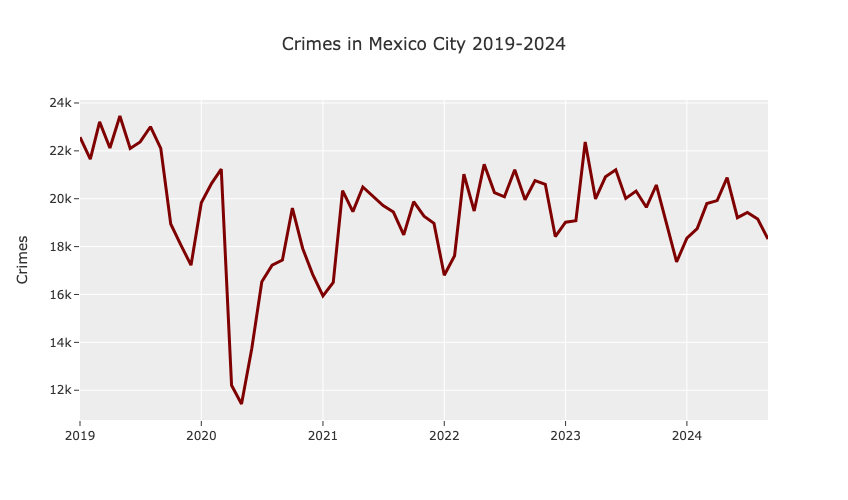

In [19]:
#| label: fig-time
#| fig-cap: "Time Behavior of Crimes in Mexico City"
#| fig-cap-location: margin

fig = px.line(months, 
             x='fecha_inicio',
             y='crimes',
             hover_data=['fecha_inicio','crimes',],
             height=500,
             width=830,
             title='Crimes in Mexico City 2019-2024',
             template='ggplot2',)

fig.update_layout(
    xaxis=dict(title=dict(text='')),
    yaxis=dict(title=dict(text='Crimes')),
    )

fig.update_traces(line_color='#7f0000',
                  line={'width':3},
                  )

fig.show()

## Crimes by sex

In [20]:
df_sex = (
    df.group_by('sexo')
        .agg(pl.len().alias('crimes'))
)

In [21]:
# convert to pandas
df_sex = df_sex.to_pandas()
# rename row
df_sex['sexo'] = df_sex['sexo'].replace({None:'NA'})

In [24]:
#| label: tbl-sex
#| tbl-cap: "Accrued Crimes in Mexico City by Sex"
#| tbl-cap-location: margin

(
    df_sex
        .sort_values('crimes')
        .style.format(
            {
            'crimes':'{:,.0f}',
            }
        ).hide(axis='index')
)

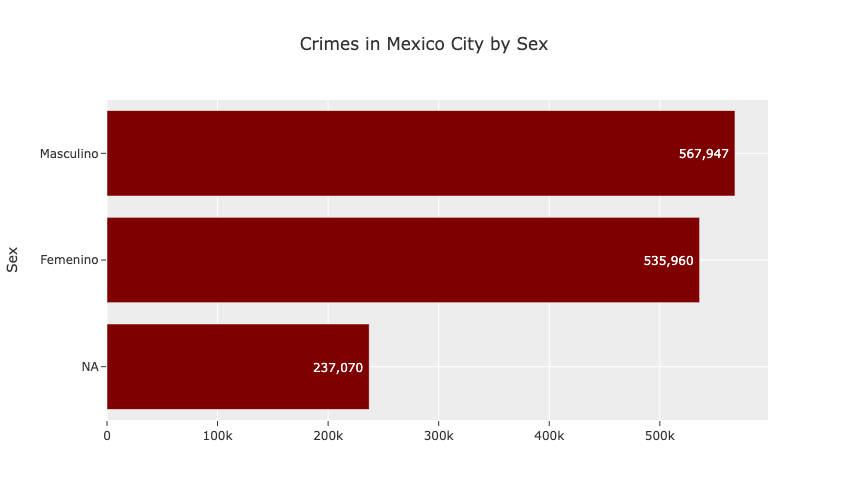

In [26]:
#| label: fig-sex
#| fig-cap: "Accrued Crimes in Mexico City by Sex"
#| fig-cap-location: margin

fig = px.bar(df_sex.sort_values('crimes'),
             y='sexo',
             x='crimes',
             orientation='h',
             hover_data=['sexo','crimes',],
             height=500,
             width=830,
             title='Crimes in Mexico City by Sex',
             template='ggplot2',
             text='crimes',
             )

fig.update_layout(
    xaxis=dict(title=dict(text='')),
    yaxis=dict(title=dict(text='Sex')),
    )

fig.update_traces(marker_color='#7f0000',
                 texttemplate = "%{value:,.0f}",)

fig.show()

## Crimes by age

In [27]:
df_edad = (
    df.group_by('edad')
        .agg(pl.len().alias('crimes'))
        .sort('edad')
        .drop_nulls()
)

In [28]:
#| label: tbl-age
#| tbl-cap: "Accrued Crimes in Mexico City by Age"
#| tbl-cap-location: margin

(
    df_edad
        .to_pandas()
        .sample(10)
        .style.format(
            {
            'edad':'{:,.0f}',
            'crimes':'{:,.0f}',
            }
        ).hide(axis='index')
)

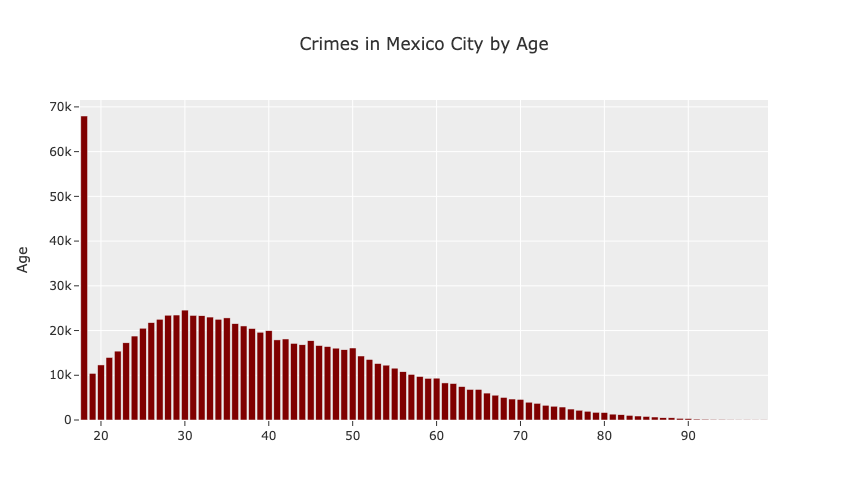

In [29]:
#| label: fig-age
#| fig-cap: "Crimes in Mexico City by Age Distribution"
#| fig-cap-location: margin

fig = px.bar(df_edad,
             x='edad',
             y='crimes',
             orientation='v',
             hover_data=['edad','crimes',],
             height=500,
             width=830,
             title='Crimes in Mexico City by Age',
             template='ggplot2',)

fig.update_layout(
    xaxis=dict(title=dict(text='')),
    yaxis=dict(title=dict(text='Age')),
    )

fig.update_traces(marker_color='#7f0000',)

fig.show()

## Crimes by neighborhood

In [30]:
df_colonia = (
    df.group_by('colonia_hecho')
        .agg(pl.len().alias('crimes'))
        .top_k(10, by='crimes')
        .sort('crimes', descending=False)
)

In [31]:
#| label: tbl-neighborhood
#| tbl-cap: "Accrued Crimes in Mexico City by Neighborhood"
#| tbl-cap-location: margin

(
    df_colonia
        .to_pandas()
        .style.format(
            {
            'crimes':'{:,.0f}',
            }
        ).hide(axis='index')
)

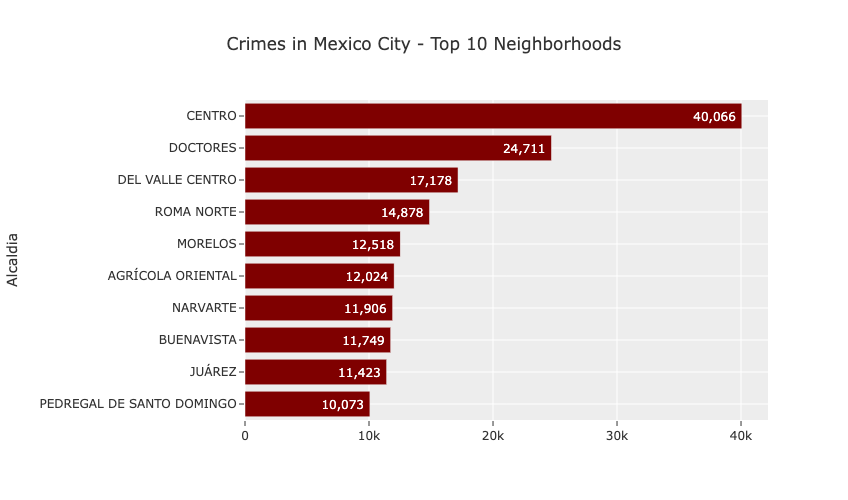

In [32]:
#| label: fig-neighborhood
#| fig-cap: "Crimes in Mexico City by Neighborhood"
#| fig-cap-location: margin

fig = px.bar(df_colonia,
             y='colonia_hecho',
             x='crimes',
             orientation='h',
             hover_data=['colonia_hecho','crimes',],
             height=500,
             width=830,
             title='Crimes in Mexico City - Top 10 Neighborhoods',
             template='ggplot2',)

fig.update_layout(
    xaxis=dict(title=dict(text='')),
    yaxis=dict(title=dict(text='Alcaldia')),
    )

fig.update_traces(marker_color='#7f0000',
                 texttemplate = "%{value:,.0f}",)

fig.show()

## Crimes by mayorship

In [33]:
df_alcaldia = (
    df.group_by('alcaldia_hecho')
        .agg(pl.len().alias('crimes'))
        .sort('crimes')
        .filter(pl.col('alcaldia_hecho')!='FUERA DE CDMX')
)

In [34]:
#| label: tbl-mayorship
#| tbl-cap: "Accrued Crimes in Mexico City by Mayorship"
#| tbl-cap-location: margin

(
    df_alcaldia
        .to_pandas()
        .style.format(
            {
            'crimes':'{:,.0f}',
            }
        ).hide(axis='index')
)

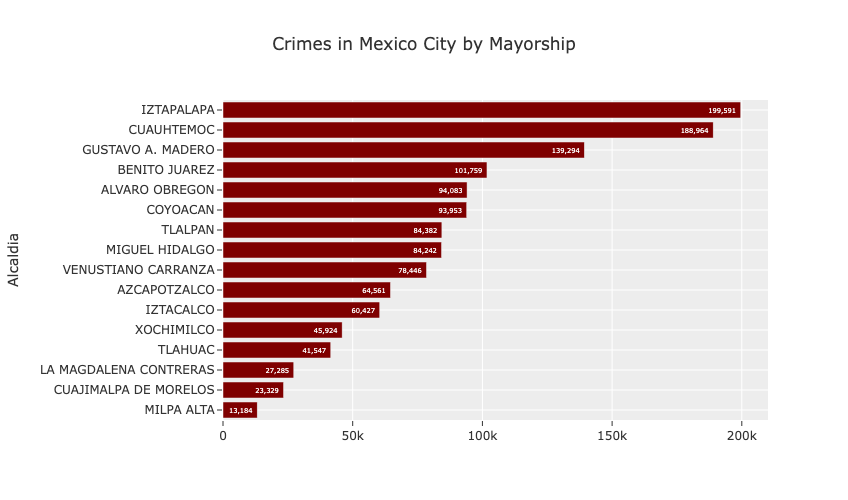

In [35]:
#| label: fig-mayorship
#| fig-cap: "Crimes in Mexico City by Mayorship"
#| fig-cap-location: margin

fig = px.bar(df_alcaldia,
             y='alcaldia_hecho',
             x='crimes',
             orientation='h',
             hover_data=['alcaldia_hecho','crimes',],
             height=500,
             width=830,
             title='Crimes in Mexico City by Mayorship',
             template='ggplot2',)

fig.update_layout(
    xaxis=dict(title=dict(text='')),
    yaxis=dict(title=dict(text='Alcaldia')),
    )

fig.update_traces(marker_color='#7f0000',
                 texttemplate = "%{value:,.0f}",)

fig.show()

## Heat map of crimes 

In [42]:
df_map = (
    df.with_columns(
        (pl.col('colonia_hecho') + ', ' + pl.col('alcaldia_hecho')).alias('neighborhood')
    )
        .filter(pl.col('alcaldia_hecho')!='FUERA DE CDMX')
        .group_by('neighborhood', maintain_order=True)
        .agg(latitude=pl.col('latitud').mean(),
             longitude=pl.col('longitud').mean(),
             crimes=pl.col('delito').len()
            )
)

In [43]:
heat_map = df_map.to_pandas()

In [48]:
#| label: tbl-heatmap
#| tbl-cap: "Crimes in Mexico City Heatmap"
#| tbl-cap-location: margin

(
    heat_map.sort_values('crimes', ascending=False)
        .head(10)
        .style.format(
        {
            'latitude':'{:,.4f}',
            'longitude':'{:,.4f}',
            'crimes':'{:,.0f}',
        }
        ).hide(axis='index')
)

In [49]:
from folium.plugins import HeatMap

basemap = folium.Map(location=[19.35, -99.12], zoom_start=10.4)

In [50]:
HeatMap(heat_map[['latitude', 'longitude', 'crimes']]).add_to(basemap)

In [52]:
#| label: fig-heatmap-mayorships
#| fig-cap: "Mexico City Crime Heatmap by Mayorship"
#| fig-cap-location: margin

folium.plugins.Fullscreen().add_to(basemap)
basemap

In [56]:
#| label: fig-hubs
#| fig-cap: "Mexico City Crime Hubs by Neighborhood"
#| fig-cap-location: margin

# mexico city crime map
m = folium.Map(
    location=[19.35, -99.12],
    zoom_start=10,
    control_scale=False,
)
# Layers
Crime = folium.FeatureGroup(name='<u><b>Place</b></u>', show=True)
m.add_child(Crime)
#draw marker with symbol you want at base
my_symbol_css_class= """ <style>
.fa-mysymbol3:before {
    font-family: Gill Sans; 
    font-weight: bold;
    font-size: 11px;
    color: white;
    background-color:'';
    border-radius: 10px; 
    white-space: pre;
    content: 'P';
    }
</style>    
        """
# the below is just add above  CSS class to folium root map      
m.get_root().html.add_child(folium.Element(my_symbol_css_class))
# then we just create marker and specific your css class in icon like below
for i in heat_map.index:
   html=f"""
        <p style="font-size: 14px;">{heat_map.iloc[i]['neighborhood']}</font></p>
        <p style="font-size: 14px;">Total crimes: {heat_map.iloc[i]['crimes']}</font></p>
        """
   iframe = folium.IFrame(html=html, width=220, height=90)
   popup = folium.Popup(iframe, max_width=250)
   folium.Marker(
        location = [heat_map.iloc[i]['latitude'], heat_map.iloc[i]['longitude']],
        icon = folium.Icon(color='darkred', prefix='fa', icon='fa-mysymbol3'),
        popup = popup,
        tooltip = heat_map.iloc[i]['neighborhood']
    ).add_to(Crime)
folium.plugins.Fullscreen().add_to(m)
m

# Conclusions

Analyzing crime in Mexico City presents significant challenges, and the limitations of available data create substantial obstacles to drawing definitive conclusions. 

- Varied Crime Landscape:

  Mexico City experiences a range of criminal activities, from petty theft to organized crime-related violence. This creates a multifaceted challenge for law enforcement.
    The distribution of crime is uneven, with certain areas experiencing higher rates of specific offenses.

- Impact of Socioeconomic Factors:

    Poverty, inequality, and lack of opportunity contribute to crime rates in certain neighborhoods.
    Addressing these underlying socioeconomic issues is crucial for long-term crime reduction.

- Efforts in Crime Reduction:

    Mexico City has implemented strategies, including increased data transparency and targeted policing, aimed at reducing crime.
    The use of open data policies, has shown to be a helpful tool in crime reduction.
    
- Challenges Remain:

    Despite progress, challenges persist, including issues related to organized crime, corruption, and the effectiveness of the criminal justice system.
    The issue of firearms, and their influx from the United States, is a large factor in violent crimes.
    
- The importance of Data:

    The use of data to create crime maps, and to find crime hot spots, has become a very important tool for law enforcement.

The hardship of incomplete data makes it essential to improve transparency and data sharing among all agencies involved in public security.

A significant portion of crimes goes unreported due to distrust in authorities, fear of retaliation, or the perception that reporting is futile.

This underreporting creates a distorted picture of the actual crime situation.

# References

- Portal de Datos Abiertos CdMx (2024). [Víctimas en carpetas de investigación Dataset](https://datos.cdmx.gob.mx/dataset/victimas-en-carpetas-de-investigacion-fgj/resource/d543a7b1-f8cb-439f-8a5c-e56c5479eeb5). Jan 2019 through Sept 2024. Retrieved from website


# Contact

**Jesus L. Monroy**


*Economist & Data Scientist*

[Medium](https://medium.com/@jesuslm) | [Linkedin](https://www.linkedin.com/in/j3sus-lm) | [Twitter](https://x.com/j3suslm)